In [1]:
'https://www.kaggle.com/msambare/fer2013/data'

'https://www.kaggle.com/msambare/fer2013/data'

In [2]:
!unzip 'archive.zip'

Archive:  archive.zip
replace test/angry/PrivateTest_10131363.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

#Importing the libraries

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Activation, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

In [4]:
Image_size = 48
Batch_size = 32
Channels = 3
Epochs = 25

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'train',
    shuffle = True,
    #color_mode = "grayscale",
    image_size = (Image_size, Image_size),
    batch_size = Batch_size
)

Found 28709 files belonging to 7 classes.


In [6]:
class_names = dataset.class_names
class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 48, 48, 3)
[5 0 3 2 3 3 5 3 3 3 3 2 6 3 2 6 4 4 5 0 5 5 4 3 0 6 3 3 3 3 3 4]


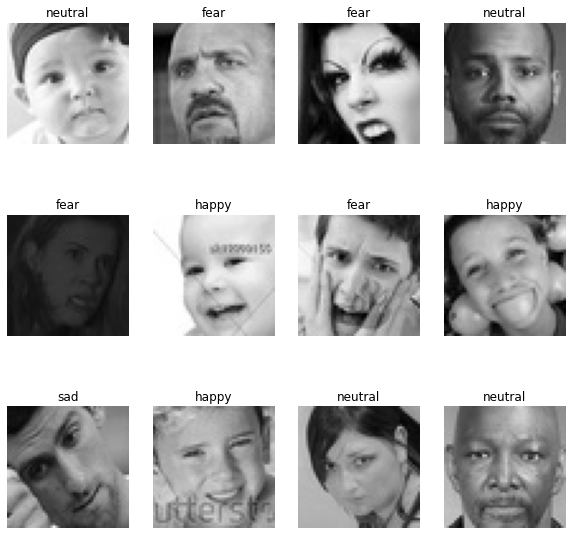

In [8]:
# showing the image 
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:
def dataset_partition(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = dataset_partition(dataset)

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [12]:
resize_and_rescaling = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_size, Image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [14]:
from tensorflow.python.keras.layers.normalization.batch_normalization import BatchNormalization
input_shape = (Image_size, Image_size, Channels)
n_classes = 7

model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(n_classes , activation='softmax'))

In [15]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [16]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        1792      
                                                                 
 module_wrapper_1 (ModuleWra  (None, 48, 48, 64)       256       
 pper)                                                           
                                                                 
 activation_1 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)      

In [17]:
history = model.fit(
    train_ds,
    epochs = Epochs,
    batch_size = Batch_size,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/25
718/718 [==============================] - 35s 25ms/step - loss: 1.7860 - accuracy: 0.3097 - val_loss: 1.7011 - val_accuracy: 0.3357
Epoch 2/25
718/718 [==============================] - 12s 17ms/step - loss: 1.4544 - accuracy: 0.4409 - val_loss: 1.2706 - val_accuracy: 0.4982
Epoch 3/25
718/718 [==============================] - 12s 17ms/step - loss: 1.2987 - accuracy: 0.5057 - val_loss: 1.1812 - val_accuracy: 0.5572
Epoch 4/25
718/718 [==============================] - 13s 18ms/step - loss: 1.2161 - accuracy: 0.5343 - val_loss: 1.1182 - val_accuracy: 0.5660
Epoch 5/25
718/718 [==============================] - 13s 18ms/step - loss: 1.1520 - accuracy: 0.5602 - val_loss: 1.1392 - val_accuracy: 0.5625
Epoch 6/25
718/718 [==============================] - 13s 18ms/step - loss: 1.0926 - accuracy: 0.5882 - val_loss: 1.0668 - val_accuracy: 0.5959
Epoch 7/25
718/718 [==============================] - 13s 18ms/step - loss: 1.0385 - accuracy: 0.6086 - val_loss: 1.0089 - val_accuracy:

In [18]:
scores = model.evaluate(test_ds)

91/91 [==============================] - 7s 7ms/step - loss: 0.4687 - accuracy: 0.8774


In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

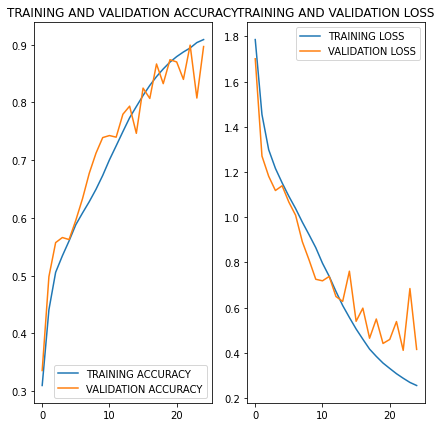

In [20]:
plt.figure(figsize = (7,7))
plt.subplot(1,2,1)
plt.plot(range(Epochs), acc, label = 'TRAINING ACCURACY')
plt.plot(range(Epochs), val_acc, label = 'VALIDATION ACCURACY')
plt.legend(loc = 'lower right')
plt.title('TRAINING AND VALIDATION ACCURACY')

plt.subplot(1,2,2)
plt.plot(range(Epochs), loss, label = 'TRAINING LOSS')
plt.plot(range(Epochs), val_loss, label = 'VALIDATION LOSS')
plt.legend(loc = 'upper right')
plt.title('TRAINING AND VALIDATION LOSS')
plt.show()

In [30]:
import pickle
pickle.dump(model, open('Emotion_detection.sav', 'wb'))

INFO:tensorflow:Assets written to: ram://cb9fa0ba-fe9a-4efa-9149-39894929c358/assets


In [45]:
ds = tf.keras.preprocessing.image_dataset_from_directory(
    'test',
    shuffle = True,
    #color_mode = "grayscale",
    image_size = (Image_size, Image_size),
    batch_size = Batch_size
)

Found 7178 files belonging to 7 classes.


In [46]:
my_model = pickle.load(open('Emotion_detection.sav', 'rb'))

In [47]:
classes = ds.class_names
class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

FIRST IMAGE TO PREDICT :
ACTUAL IMAGE : neutral
PREDICED LABEL : neutral


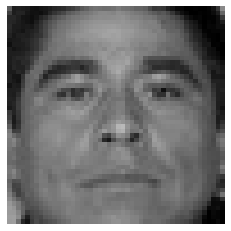

In [48]:
for image_batches, label_batches in ds.take(1):
    first_image = image_batches[0].numpy().astype('uint8')
    first_label = label_batches[0].numpy()
    
    print('FIRST IMAGE TO PREDICT :')
    plt.imshow(first_image)
    plt.axis('off')
    print('ACTUAL IMAGE :', class_names[first_label])
    
    batch_prediction = my_model.predict(image_batches)
    batch_prediction = class_names[np.argmax(batch_prediction[0])]
    print('PREDICED LABEL :',batch_prediction)

In [49]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #create a batch
    
    predictions = my_model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


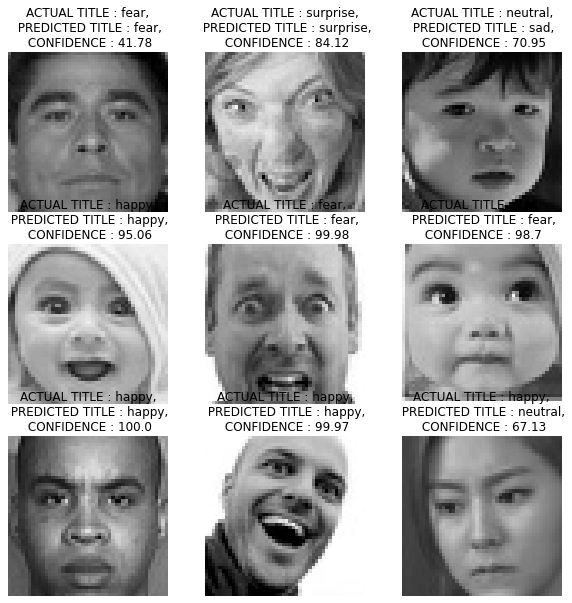

In [53]:
plt.figure(figsize = (10, 10))
for images, labels in ds.take(5):
    for i in range(9):
        ax = plt.subplot(3, 3, i +1)
        plt.imshow(image_batches[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(my_model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f'ACTUAL TITLE : {actual_class},\n PREDICTED TITLE : {predicted_class},\n CONFIDENCE : {confidence}')
        plt.axis('off')